In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import export_text
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("ksi_collisions.csv")

In [3]:
df.sample(2)

,DATE,STREET1,STREET2,DISTRICT,LATITUDE,LONGITUDE,VISIBILITY,LIGHT,ROAD_CONDITION,ACCLASS,...,DOW,HOUR,YEAR,MONTH,SEVERE_COLLISION,TIME_OF_DAY,SEASON,VEHICLE_TYPE,DRIVER_ACTION,IMPACT_TYPE
9271,2013-03-16,WARDEN AVE,STEELES AVE E,Scarborough,43.819645,-79.32439,Clear,Daylight,Dry,Non-Fatal Injury,...,Saturday,12,2013,3,0,MorningAfternoon,Spring,Car,Control/Maneuver Error,Pedestrian/Cyclist
6658,2011-01-22,F G GARDINER XY Expr E,JAMESON AVE,Toronto and East York,43.632445,-79.43279,Clear,Dark,Dry,Non-Fatal Injury,...,Saturday,3,2011,1,0,LateNight,Winter,Car,Other/Unknown,Rear End


In [4]:
categorical_features = ['LIGHT', 'VISIBILITY', 'ROAD_CONDITION', 'DOW', 'TIME_OF_DAY', 'SEASON', 'VEHICLE_TYPE', 'DRIVER_ACTION', 'IMPACT_TYPE']

In [5]:
target = 'SEVERE_COLLISION'

In [6]:
X = df[categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=65,
        max_depth=9,
        max_features = 'sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

In [8]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      2021
           1       0.65      0.67      0.66      1725

    accuracy                           0.68      3746
   macro avg       0.68      0.68      0.68      3746
weighted avg       0.68      0.68      0.68      3746



In [ ]:
x_pred = model.predict(X_)

In [10]:
model.score(X_test, y_test)

0.6793913507741591

In [11]:
sample = {
    'LIGHT': 'Daylight',
    'VISIBILITY': 'Clear',
    'ROAD_CONDITION': 'Dry',
    'DOW': 'Friday',
    'TIME_OF_DAY': 'Evening',
    'SEASON': 'S',
    'VEHICLE_TYPE': 'Car',
    'DRIVER_ACTION': 'Failed to Yield Right of Way',
    'IMPACT_TYPE': 'T-Bone'
}

sample_df = pd.DataFrame([sample])

In [12]:
prediction = model.predict(sample_df)[0]
probability = model.predict_proba(sample_df)[0][1]
print(f"Predicted class: {prediction} (1 = Severe, 0 = Not Severe)")
print(f"Probability of severe collision: {probability:.3f}")

Predicted class: 0 (1 = Severe, 0 = Not Severe)
Probability of severe collision: 0.345


In [13]:
valid_categories = {
    col: set(X_train[col].dropna().unique())
    for col in categorical_features
}

print(valid_categories)

{'LIGHT': {'Dark', 'Daylight', 'Twilight'}, 'VISIBILITY': {'Clear', 'Rain', 'Snow'}, 'ROAD_CONDITION': {'Wet', 'Dry', 'SnowIce'}, 'DOW': {'Friday', 'Sunday', 'Thursday', 'Saturday', 'Monday', 'Tuesday', 'Wednesday'}, 'TIME_OF_DAY': {'MorningAfternoon', 'Evening', 'LateNight', 'Night'}, 'SEASON': {'Summer', 'Spring', 'Winter', 'Fall'}, 'VEHICLE_TYPE': {'Two Wheeler', 'Truck', 'Bus', 'Car', 'Emergency'}, 'DRIVER_ACTION': {'Right-of-Way/Traffic Violation', 'Speed-Related', 'Other/Unknown', 'Control/Maneuver Error'}, 'IMPACT_TYPE': {'Sideswipe/Approaching', 'Slow/Parked', 'Pedestrian/Cyclist', 'Rear End', 'T-Bone'}}


In [ ]:
#save model
joblib.dump({
    "model": model,
    "valid_categories": valid_categories
}, "model.joblib")

In [14]:
y_proba = model.predict_proba(df)[:, 1]

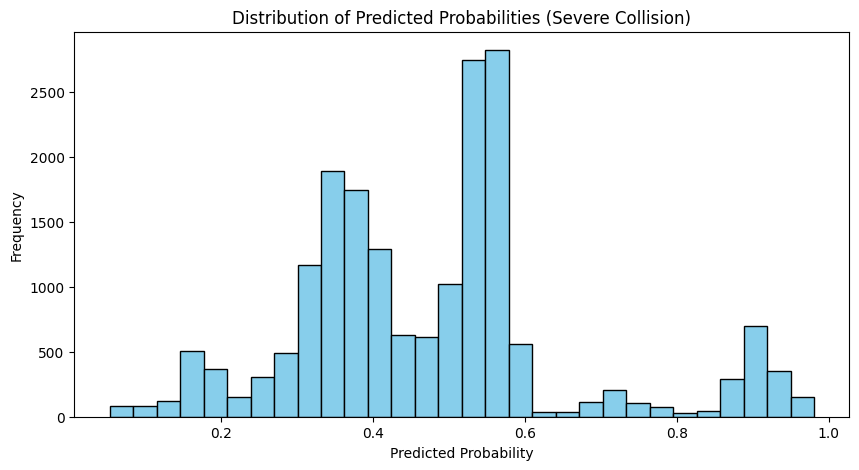

In [15]:
plt.figure(figsize=(10,5))
plt.hist(y_proba, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Probabilities (Severe Collision)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

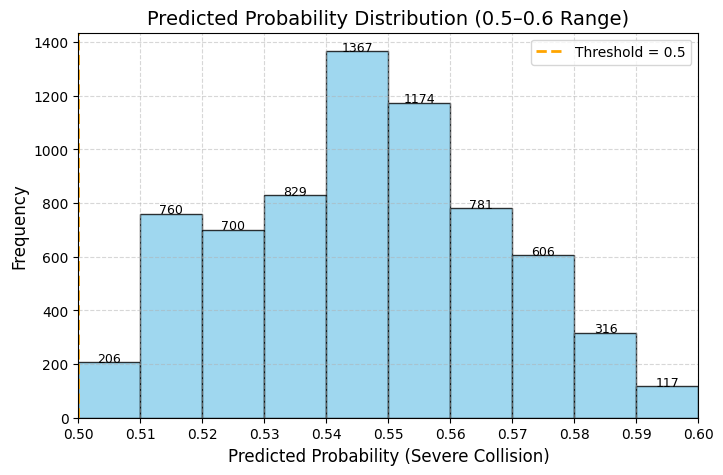

In [16]:
bins = np.arange(0.5, 0.61, 0.01)

plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(
    y_proba, bins=bins, color='skyblue', edgecolor='black', alpha=0.8
)

plt.title("Predicted Probability Distribution (0.5–0.6 Range)", fontsize=14)
plt.xlabel("Predicted Probability (Severe Collision)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

for i, count in enumerate(counts):
    plt.text(bins[i] + 0.005, count + 0.5, str(int(count)), ha='center', fontsize=9)

plt.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Threshold = 0.5')

plt.xlim(0.5, 0.6)
plt.xticks(np.arange(0.5, 0.61, 0.01))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()